# Pareto decoding 

This notebook is a work in progress.

Given two edge weight functions, find the set of argmaxes for *all* linear combinations of those edge weights.

Where do these edge functions come from?
 - two parameter vectors with shared linear features; Pareto decoding can be used to do exact and efficient line search.

In [13]:
import numpy as np
import pylab as pl

from hypergraphs.semirings import LazySort, ConvexHull, Point, post_process
from hypergraphs.apps.parser2 import parse, load_grammar

In [41]:
def binary(sentence,X,Y,Z,i,j,k):
    return ConvexHull([Point(w1(X,Y,Z,i,j,k), w2(X,Y,Z,i,j,k), X)])

def unary(sentence,X,Y,i,k):
    return ConvexHull([Point(w1(X,Y,i,k), w2(X,Y,i,k), X)])

def terminal(sentence,W,i):
    return ConvexHull([Point(0.0, 0.0, W)])

from arsenal.cache import memoize
w1 = memoize(lambda *edge: np.random.uniform(-1,1))
w2 = memoize(lambda *edge: np.random.uniform(-1,1))

sentence = 'Papa ate the caviar with the spoon .'.split()

grammar = load_grammar("""
S       X .
X       X X
X       Papa
X       ate
X       the
X       caviar
X       with
X       spoon
X       in
X       park
""")

root = parse(sentence, grammar, binary, unary, terminal, zero = ConvexHull([]))[0,len(sentence),'S']

Below, we plot the convex hull found.  The x-axis and y-axis are the scores under the different weight vectors.

- *TODO*: label the axes.

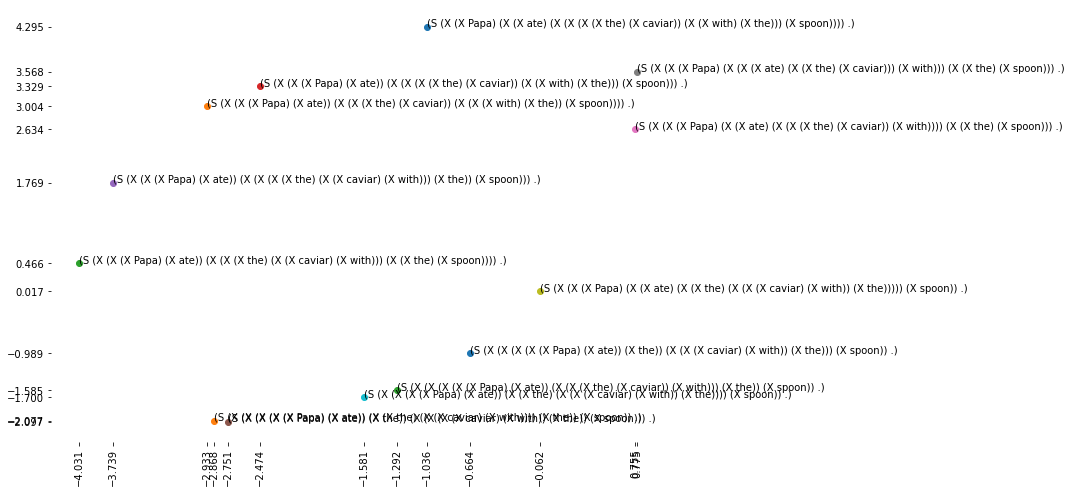

In [42]:
import re
ax = pl.figure(figsize=(11,8)).add_subplot(111)
pl.box(False)
pl.xticks([x.m for x in root], rotation='vertical')
pl.yticks([x.b for x in root])
for x in root:
    pl.scatter(x.m, x.b)
    pl.text(x=x.m, y=x.b, s=re.sub('\s+', ' ', str(x.derivation())))

**TODO**

- Explain what Pareto decoding is (i.e., decoding under all combinations of two edge scoring functions); 
  - unit-test that the interpretation is correct.
- Clean up the creation of the hypergraph and the scoring
- Visualize *every* parse in the two-dimensional plot and show that we are only selecting the one on the convex hull.  This is the main different between `ConvexHull` (polytime) and `LazySort` (exptime).
- Give references to Dyer's tutorial, Och's MERT paper, as well as work in multi-objective RL
- Convex hull semiring is max-plus so it requires working with log-weights

In [43]:
def binary(sentence,X,Y,Z,i,j,k):
    return LazySort(np.exp(w1(X,Y,Z,i,j,k)), X)

def unary(sentence,X,Y,i,k):
    return LazySort(np.exp(w1(X,Y,i,k)), X)

def terminal(sentence,W,i):
    return LazySort(1.0, W)

root1 = parse(sentence, grammar, binary, unary, terminal, zero = LazySort.zero())[0,len(sentence),'S']

In [44]:
def binary(sentence,X,Y,Z,i,j,k):
    return LazySort(np.exp(w2(X,Y,Z,i,j,k)), X)

def unary(sentence,X,Y,i,k):
    return LazySort(np.exp(w2(X,Y,i,k)), X)

def terminal(sentence,W,i):
    return LazySort(1.0, W)

root2 = parse(sentence, grammar, binary, unary, terminal, zero = LazySort.zero())[0,len(sentence),'S']

In [45]:
d1 = {str(x.data): np.log(x.score) for x in root1}
d2 = {str(x.data): np.log(x.score) for x in root2}

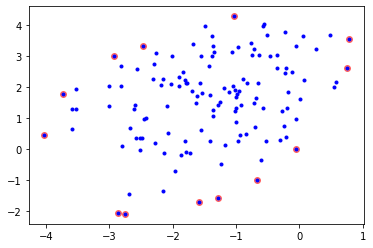

In [50]:
for x in d1:
    pl.scatter(d1[x], d2[x], c='b', marker='.')
for x in root:
    pl.scatter(x.m, x.b, c='r', alpha=0.5, zorder=-1)

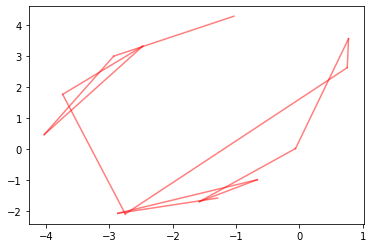

In [55]:
# TODO: return points in convex hull order!
from arsenal.iterextras import window
for x, y in window(root, 2):
    pl.plot([x.m, y.m], [x.b, y.b], c='r', alpha=0.5, zorder=-1)